In [17]:
import re
import pandas as pd
from transformers import pipeline
from datasets import Dataset

# ---------------------
# 1. 数据导入：读取 CSV 文件，并只处理指定时间段的推文

# ---------------------
df = pd.read_csv('/kaggle/input/trump-tweets/realdonaldtrump.csv')

# 转换时间列为 datetime 格式
df["created_at"] = pd.to_datetime(df["date"], errors='coerce')

# 筛选指定时间范围内的推文
start_date = "2017-01-20"
end_date = "2021-01-20"
df = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()

# ---------------------
# 2. 数据清洗：简单清洗文本
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9\u4e00-\u9fa5\s]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["clean_tweet"] = df["content"].astype(str).apply(clean_text)
df = df[df["clean_tweet"].notnull()]  # 去除 NaN
df = df[df["clean_tweet"].str.strip() != ""]  # 去除空字符串

dataset = Dataset.from_pandas(df[["clean_tweet"]])

# ---------------------
# 3. Zero-Shot 分类：加载模型和定义分类类别
# ---------------------
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli")

categories = [
    "Domestic Politics",
    "Economy & Finance",
    "Foreign Policy",
    "Law & Justice",
    "National Security & Military",
    "Media & Fake News",
    "Self-Promotion & Branding",
    "Public Reaction & Social Issues",
    "Other / General"
]

Device set to use cuda:0


In [18]:
from tqdm import tqdm

def classify_tweets_batch(texts, batch_size=256):
    labels = []
    scores = []
    num_batches = (len(texts) + batch_size - 1) // batch_size

    for i in tqdm(range(num_batches), desc="Classifying tweets"):
        batch_texts = texts[i * batch_size : (i + 1) * batch_size]
        try:
            results = classifier(batch_texts, candidate_labels=categories, batch_size=batch_size)
            labels.extend([r["labels"][0] for r in results])
            scores.extend([r["scores"][0] for r in results])
        except Exception as e:
            print(f"Batch {i+1} fail: {e}")
            labels.extend(["Unclassified"] * len(batch_texts))
            scores.extend([0.0] * len(batch_texts))
    
    return labels, scores


# ---------------------
# 4. 分类并保存结果
# ---------------------
labels, scores = classify_tweets_batch(df["clean_tweet"].tolist())
df["Predicted_Category"] = labels
df["Prediction_Score"] = scores

# 只保存处理后的数据到 CSV
df.to_csv("/kaggle/working/classified_tweets_2017_2021.csv", index=False)
print("finish, saved in classified_tweets_2017_2021.csv")


Classifying tweets: 100%|██████████| 47/47 [14:34<00:00, 18.60s/it]

finish, saved in classified_tweets_2017_2021.csv


<Axes: xlabel='Predicted_Category'>

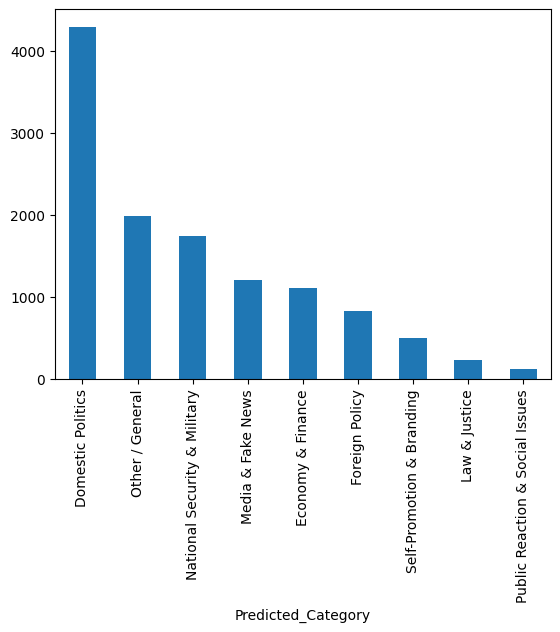

In [20]:
df['Predicted_Category'].value_counts().plot(kind='bar')


<Axes: title={'center': 'Time trend'}, xlabel='month'>

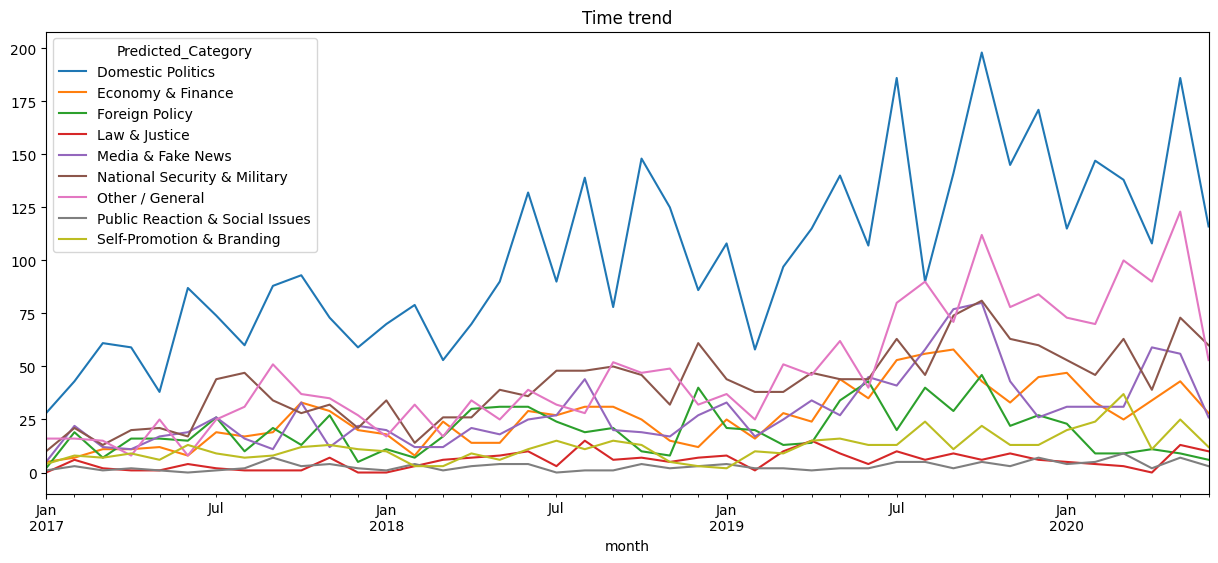

In [25]:
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M")
df = df.groupby(["month", "Predicted_Category"]).size().unstack().fillna(0)

df.plot(figsize=(15,6), title="Time trend")


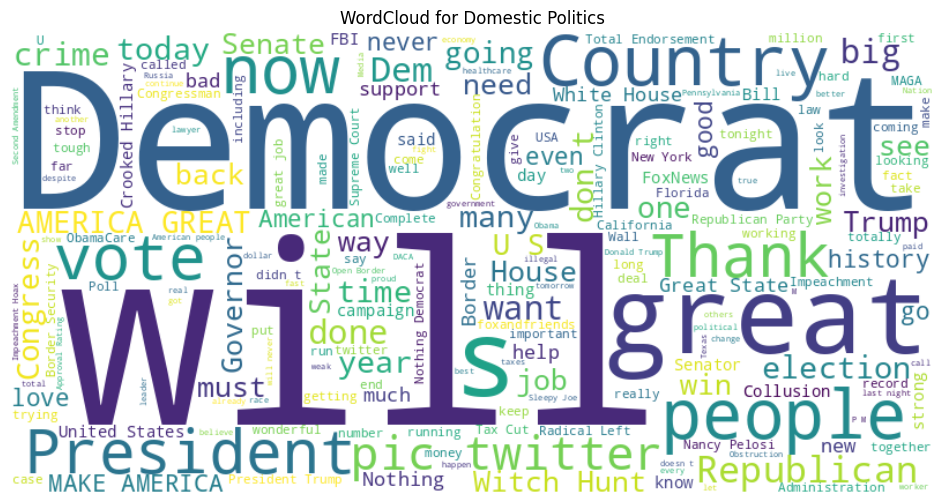

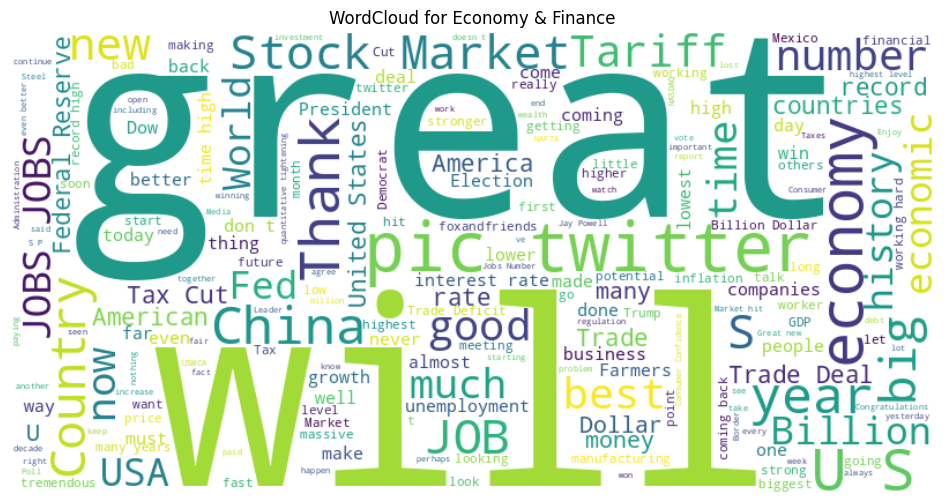

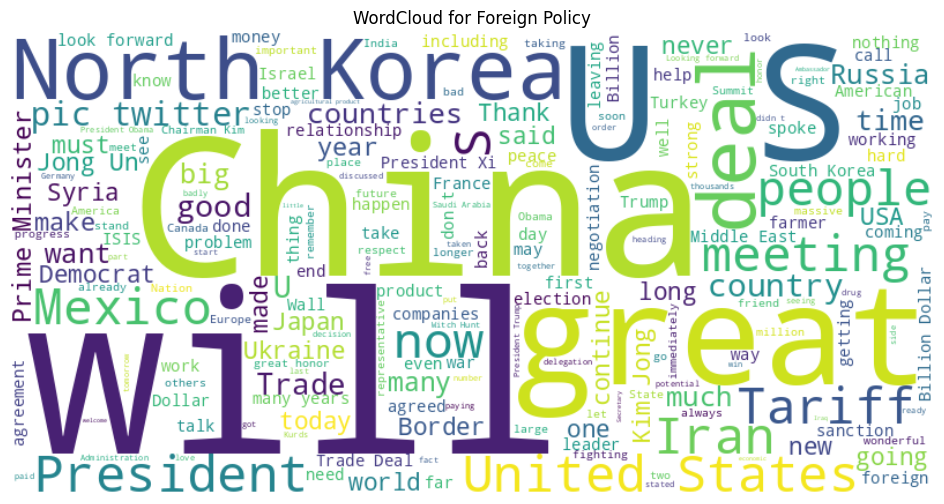

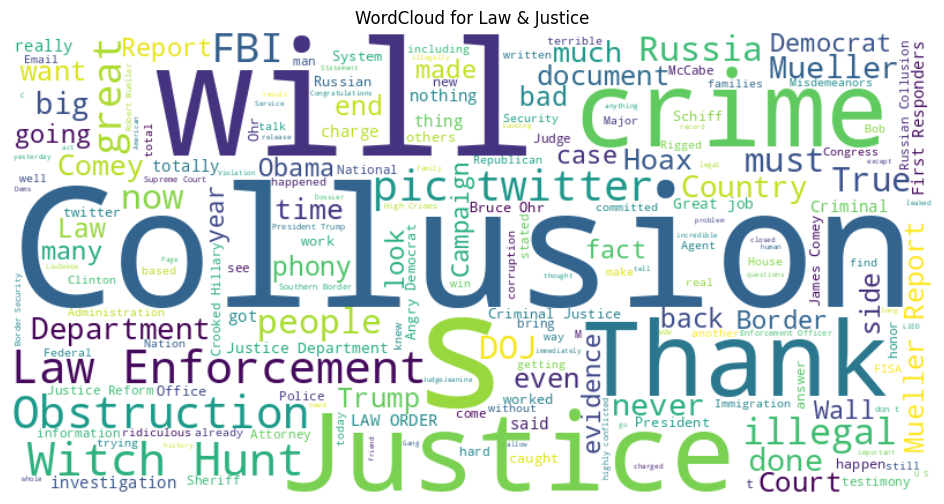

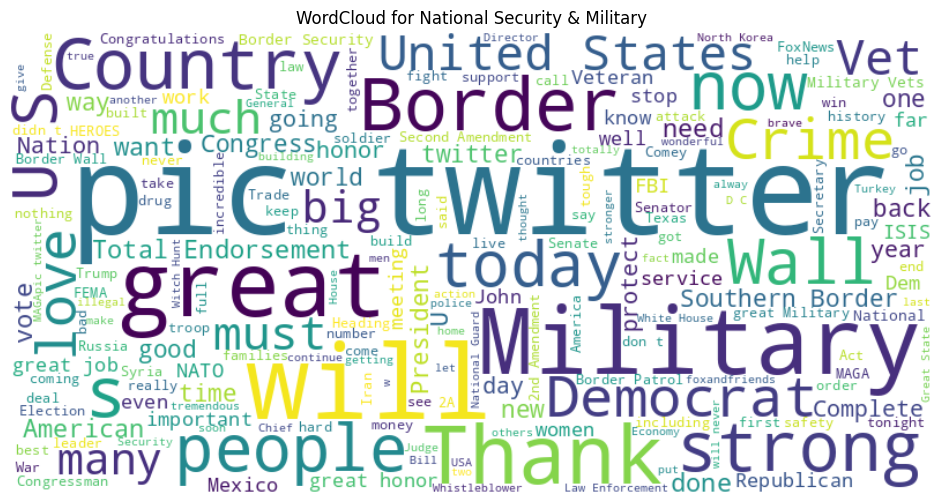

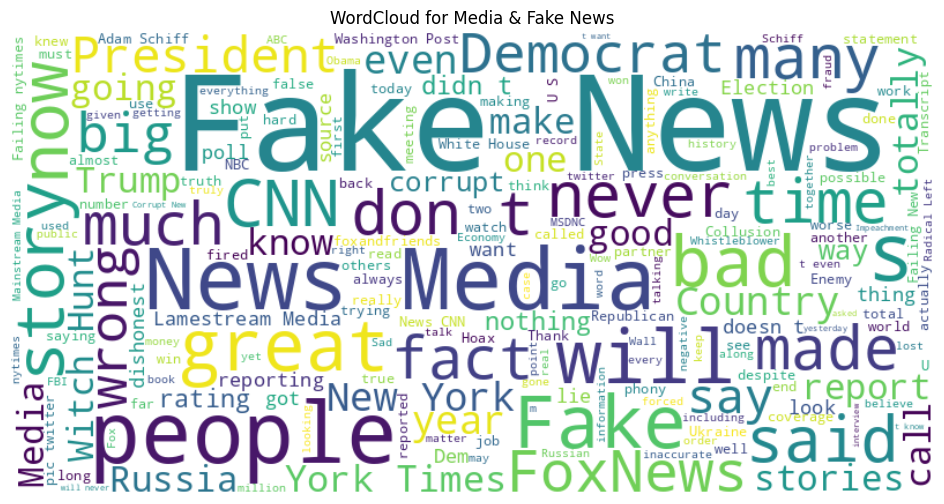

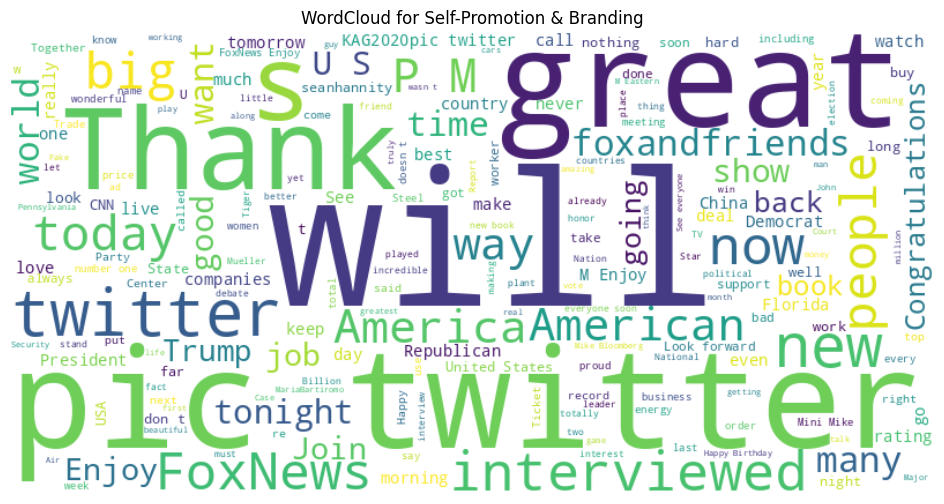

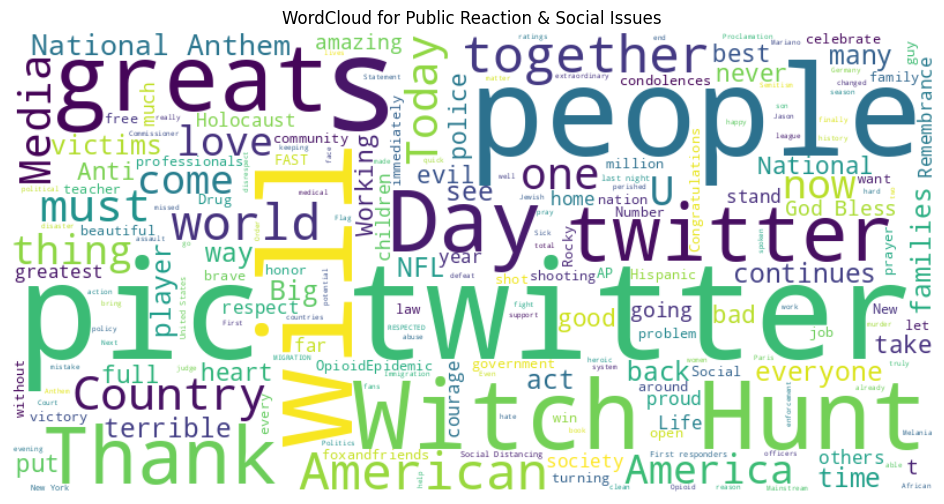

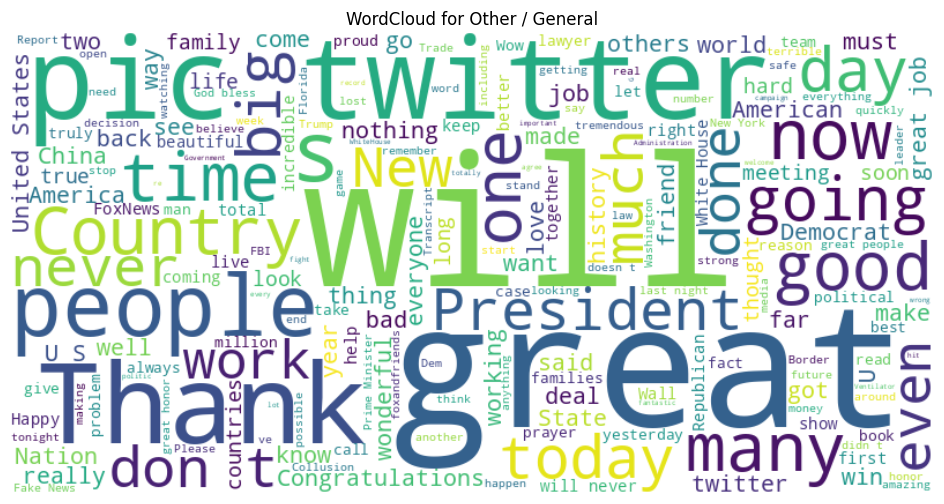

In [35]:
# # 安装 wordcloud 和 matplotlib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
df = pd.read_csv('/kaggle/input/classified-tweets/classified_tweets.csv')

for x in categories:
    text = " ".join(df[df["Predicted_Category"] == x]["clean_tweet"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud for "+ x )
    plt.show()


In [41]:
!pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.9 MB/s eta 0:00:00


In [48]:
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

df = pd.read_csv('/kaggle/input/classified-tweets/classified_tweets.csv')
# df["created_at"] = pd.to_datetime(df["created_at"], errors='coerce')

In [43]:
# # 筛选指定时间范围内的推文
# start_date = "2017-01-20"
# end_date = "2021-01-20"
# df = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()

In [44]:
analyzer = SentimentIntensityAnalyzer()

In [49]:
# 定义一个函数来获取情感分数
def get_sentiment_scores(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score

# ---------------------
# 4. 批量处理：批量分析推文，并显示进度
# ---------------------
def batch_sentiment_analysis(df, batch_size=64):
    labels = []
    scores = []
    num_batches = (len(df) + batch_size - 1) // batch_size  # 计算批次数

    # 使用 tqdm 显示进度条
    for i in tqdm(range(num_batches), desc="Classifying tweets"):
        batch_df = df.iloc[i * batch_size: (i + 1) * batch_size]  # 获取当前批次的数据
        batch_scores = batch_df["clean_tweet"].apply(get_sentiment_scores)  # 获取情感分数
        
        # 分解情感分数
        labels_batch = batch_scores.apply(lambda x: x['compound'])
        neg_batch = batch_scores.apply(lambda x: x['neg'])
        neu_batch = batch_scores.apply(lambda x: x['neu'])
        pos_batch = batch_scores.apply(lambda x: x['pos'])

        labels.extend(labels_batch)
        scores.extend(list(zip(neg_batch, neu_batch, pos_batch)))  # 保存每条推文的分数
    
    return labels, scores

# 获取情感分数
labels, scores = batch_sentiment_analysis(df)

# ---------------------
# 5. 将结果保存到 CSV 文件
# ---------------------
df["compound"] = labels  # 保存情感分数
df[["neg", "neu", "pos"]] = pd.DataFrame(scores, index=df.index)  # 保存负面、中性、正面情感分数

# df_result = df[["date", "content", "clean_tweet", "neg", "neu", "pos", "compound"]]
df.to_csv("/kaggle/working/sentiment_classified_tweets_2017_2021_batch.csv", index=False)

print("✅ Done. Sentiment scores saved in 'sentiment_classified_tweets_2017_2021_batch.csv'.")

Classifying tweets: 100%|██████████| 188/188 [00:02<00:00, 87.29it/s]


✅ Done. Sentiment scores saved in 'sentiment_classified_tweets_2017_2021_batch.csv'.


In [46]:
df.to_csv("/kaggle/working/sentiment_classified_tweets_2017_2021_batch.csv", index=False)

print("✅ Done. Sentiment scores saved in 'sentiment_classified_tweets_2017_2021_batch.csv'.")

✅ Done. Sentiment scores saved in 'sentiment_classified_tweets_2017_2021_batch.csv'.
